In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import sys
import random, pickle
from os.path import join as oj
from tqdm import tqdm
sys.path.insert(1, oj(sys.path[0], 'mnist'))
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import scipy
cs = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
sns.set_style(style='white')
sns.set_palette("husl")

import torch
import foolbox
import mnist.mnist as dset
from mnist.mnist import pred_ims
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from conv2dnp import conv2dnp
import visualize as viz
import tiling
import agglomerate
from cd import cd
import scores
import attack_helper

import warnings
warnings.filterwarnings("ignore")

# load the model
model = dset.Net().cuda()
model.load_state_dict(torch.load('mnist/mnist.model'))
model.eval()

Net(
  (conv1): Conv2d (1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50)
  (fc2): Linear(in_features=50, out_features=10)
)

# attack

In [278]:
# pick im + attack
im_nums = range(250, 275)
ats = ['fgsm'] # ['fgsm', 'saliency', 'gradientattack', 'deepfoolattack', 'boundaryattack']
for attack_type in ats:
    total_lists = []
    for im_num in tqdm(im_nums):
        # generate attack
        im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv = attack_helper.attack_im_num(im_num, attack_type)

        # aggregate
        all_lists = attack_helper.agglomerate_lists(im_orig, im_torch, im_orig_adv, im_torch_adv, label, target)
        total_lists.append((all_lists, label, target, pred_orig, pred_adv))
    pickle.dump(total_lists, open('adv_results/total_lists_' + attack_type + '.pkl', 'wb'))

100%|██████████| 1/1 [00:48<00:00, 48.27s/it]


# simple agg example

100%|██████████| 1/1 [00:06<00:00,  6.93s/it]


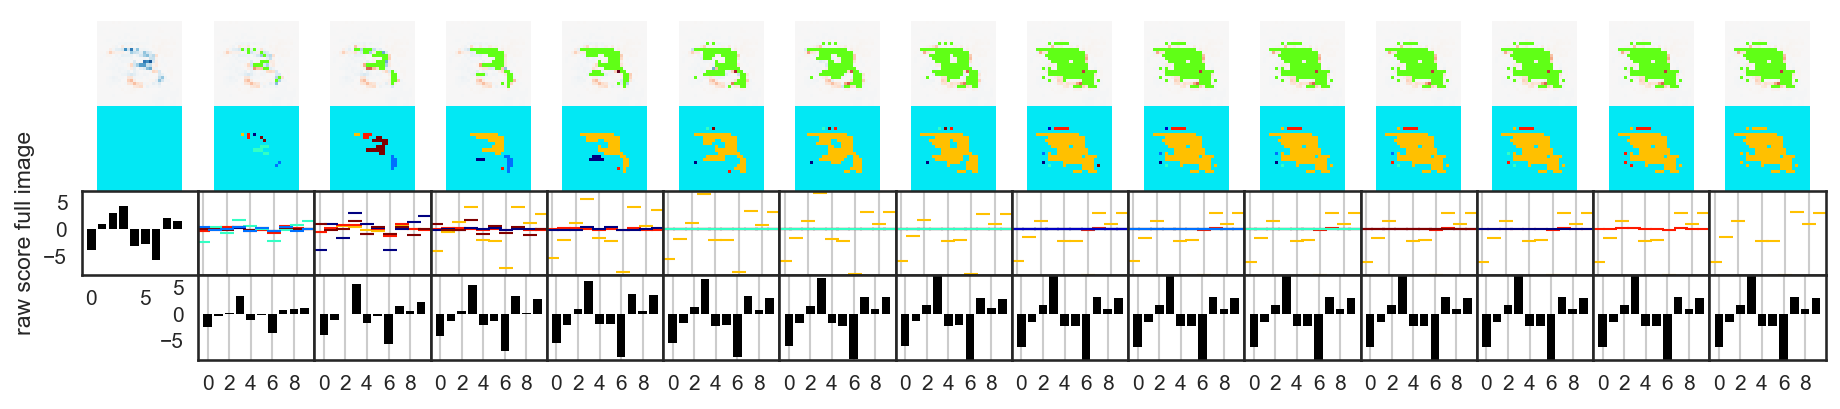

In [5]:
# pick im + attack
im_nums = range(250, 251)
ats = ['fgsm'] # ['fgsm', 'saliency', 'gradientattack', 'deepfoolattack', 'boundaryattack']
for attack_type in ats:
    total_lists = []
    for im_num in tqdm(im_nums):
        # generate attack
        im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv = attack_helper.attack_im_num(im_num, attack_type)

        
         # agg params
        method = 'cd'
        percentile_include = 98
        sweep_dim = 1
        layer = 'softmax'
        use_abs = False
        num_iters = 8
        
        # agglomerate lists
        lists_orig_lab = attack_helper.agg_and_plot(im_torch, label, im_orig, model, dset.pred_ims, percentile_include, 
             method, sweep_dim, layer, use_abs, num_iters=num_iters, plot=True)
    

# agg

In [3]:
attack_type = 'saliency' # ['fgsm', 'saliency', 'gradientattack', 'deepfoolattack', 'boundaryattack']
out_folder = 'adv_results/round3_total_lists'# 'adv_results' # 'adv_results/round2_total_lists'
total_lists = pickle.load(open(oj(out_folder, 'total_lists_' + attack_type + '.pkl'), 'rb'))
plot_sub = False
sns.set_palette("husl", 12)
# cs = ['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#ffffbf','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2']
plt.figure(figsize=(9, 3), dpi=250)
for ex_num, all_lists in enumerate(total_lists):
    ([lists_orig_lab, lists_orig_targ, lists_adv_lab, lists_adv_targ], label, target, pred_orig, pred_adv) = all_lists
    
    # check that attack is succesful
    if pred_adv[target] > pred_adv[label] and pred_orig[label] > 0.95: #pred_orig[target]:
    
        # orig
        npix_orig_lab = np.array([np.sum(np.isnan(x)) for x in lists_orig_lab['scores_list']][1:])
        tots_orig_lab = np.array([x[label] for x in lists_orig_lab['comp_scores_raw_combined_list']])
    #     npix_orig_lab = np.insert(npix_orig_lab, 0, 0)
    #     tots_orig_lab = np.insert(tots_orig_lab, 0, 0)

        npix_orig_targ = np.array([np.sum(np.isnan(x)) for x in lists_orig_lab['scores_list']][1:])
        tots_orig_targ = np.array([x[target] for x in lists_orig_lab['comp_scores_raw_combined_list']])
    #     npix_orig_targ = np.insert(npix_orig_targ, 0, 0)
    #     tots_orig_targ = np.insert(tots_orig_targ, 0, 0)

    #     print(len(npix_orig_lab))
        # adv
        npix_adv_lab = np.array([np.sum(np.isnan(x)) for x in lists_adv_lab['scores_list']][1:])
        tots_adv_lab = np.array([x[label] for x in lists_adv_lab['comp_scores_raw_combined_list']])

        npix_adv_targ = np.array([np.sum(np.isnan(x)) for x in lists_adv_lab['scores_list']][1:])
        tots_adv_targ = np.array([x[target] for x in lists_adv_lab['comp_scores_raw_combined_list']])


        plt.subplot(121)
        if plot_sub:
            plt.plot(npix_orig_lab/7.84, tots_orig_lab - tots_orig_targ, '-o', markersize=2, alpha = 0.35, label=ex_num) #color=cs[ex_num])
        else:
            if ex_num >= len(cs):
                break
            plt.plot(npix_orig_lab/7.84, tots_orig_lab, alpha = 0.35, label=ex_num, color=cs[ex_num])
            plt.plot(npix_orig_lab/7.84, tots_orig_targ, ':', alpha = 0.35, label=ex_num, color=cs[ex_num])
        plt.ylabel('Difference in total CD score\n(original class - adversarial class)')
        plt.xlabel('Percent of pixels selected (%)')
        plt.title('Original image')

        plt.subplot(122)
        if plot_sub:
            plt.plot(npix_adv_lab/7.84, tots_adv_lab - tots_adv_targ, '-o', markersize=2, alpha = 0.35, label=ex_num) #color=cs[ex_num])
        else:
            plt.plot(npix_adv_lab/7.84, tots_adv_lab, alpha = 0.35, label=ex_num, color=cs[ex_num])
            plt.plot(npix_adv_lab/7.84, tots_adv_targ, ':', alpha = 0.35, label=ex_num, color=cs[ex_num])

    #     plt.ylabel('Total CD score\nlabel - target adversarial image')
        plt.xlabel('Percent of pixels selected (%)')        
        plt.title('Adversarial Image')

bot = -1
top = 20
plt.subplot(121)
plt.xlim((0, 101))
plt.ylim((bot, top))
plt.plot([0, 100], [0, 0], '--', color='gray', alpha=0.4)

plt.subplot(122)
plt.xlim((0, 101))
plt.ylim((bot, top))
plt.gca().yaxis.set_visible(False)
plt.plot([0, 100], [0, 0], '--', color='gray', alpha=0.4)
plt.subplots_adjust(wspace=0.1)
plt.show()

ValueError: not enough values to unpack (expected 5, got 3)

<Figure size 2250x750 with 0 Axes>

In [268]:
total_lists = pickle.load(open('adv_results/total_lists_' + attack_type + '.pkl', 'rb'))
([lists_orig_lab, lists_orig_targ, lists_adv_lab, lists_adv_targ], label, target) = total_lists[0]
    
x = lists_orig_lab['im_thresh_list']
print(len(x))
[np.sum(a) for a in x]

32


[16,
 35,
 53,
 72,
 90,
 107,
 126,
 148,
 167,
 186,
 207,
 222,
 239,
 257,
 273,
 289,
 302,
 316,
 328,
 341,
 354,
 369,
 382,
 382,
 382,
 382,
 382,
 382,
 382,
 382,
 382,
 382]

# full agg plots

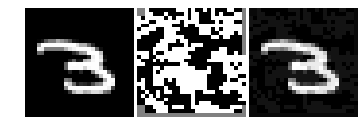

	label: 3 0.6761339 -> 0.36680317
	target: 2 0.18515798 -> 0.37429506


In [282]:
attack_helper.plot_attack(im_orig, im_orig_adv, label, target, pred_orig, pred_adv)

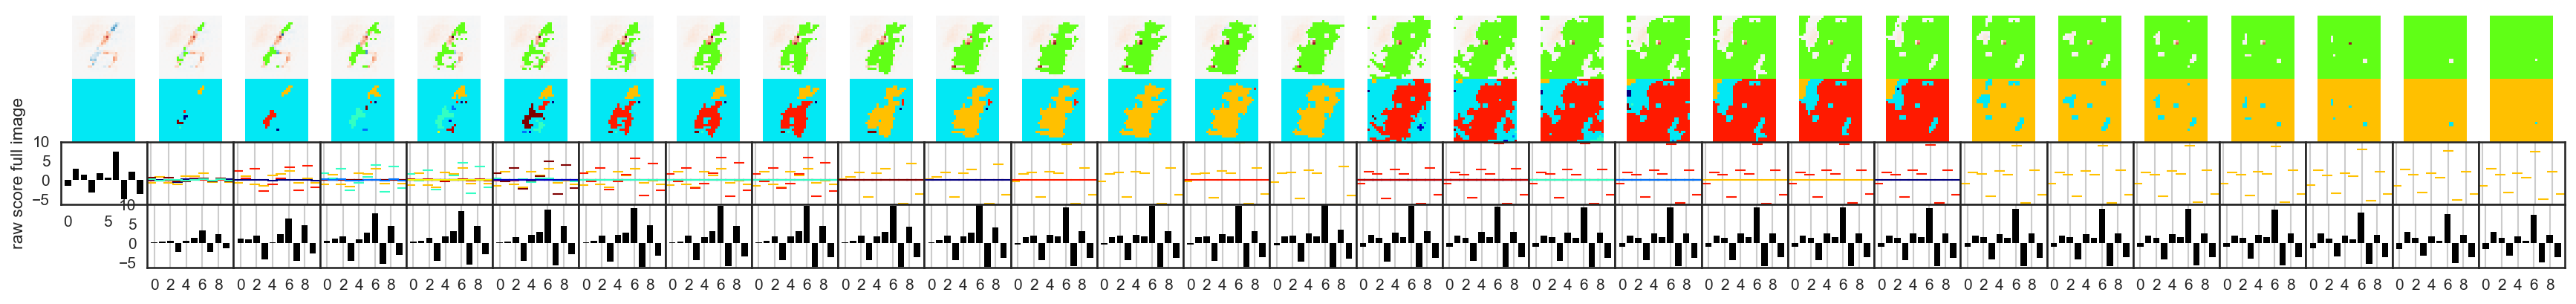

In [342]:
plot_lists(lists_orig_lab)
plt.show()
# plot_lists(lists_orig_targ)
# plt.show()
# plot_lists(lists_adv_lab)
# plt.show()
# plot_lists(lists_adv_targ)
# plt.show()

# plot all attacks

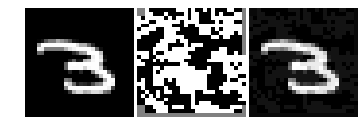

	label: 3 0.6761339 -> 0.36680317
	target: 2 0.18515798 -> 0.37429506


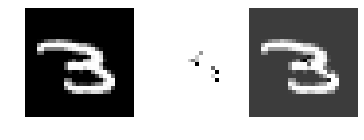

	label: 3 0.6761339 -> 0.38183555
	target: 2 0.18515798 -> 0.40505022


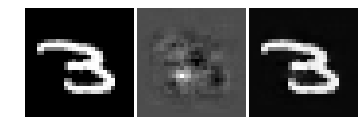

	label: 3 0.6761339 -> 0.3753697
	target: 2 0.18515798 -> 0.39490557


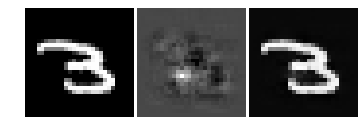

	label: 3 0.6761339 -> 0.35067138
	target: 2 0.18515798 -> 0.44998848
run with verbose=True to see details
Step 0: 1.25424e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 3190: 7.87810e-05, stepsizes = 3.4e-05/7.8e-08: 
Step 3297: 7.87809e-05, stepsizes = 1.3e-06/7.8e-08: 
Step 3298: 7.87809e-05, stepsizes = 1.3e-06/7.8e-08: 
Step 3299: 7.87809e-05, stepsizes = 1.3e-06/7.8e-08: 
Step 3300: 7.87809e-05, stepsizes = 1.3e-06/7.8e-08: 
Step 3301: 7.87809e-05, stepsizes = 8.9e-07/5.2e-08: 
Step 3302: 7.87809e-05, stepsizes = 8.9e-07/5.2e-08: 
Step 3303: 7.87809e-05, stepsizes = 8.9e-07/5.2e-08: 
Step 3304: 7.87809e-05, stepsizes = 8.9e-07/5.2e-08: 
Step 3305: 7.87809e-05, stepsizes = 5.9e-07/3.5e-08: 
Step 3306: 7.87809e-05, stepsizes = 5.9e-07/3.5e-08: 
Step 3307: 7.87809e-05, stepsizes = 5.9e-07/3.5e-08: 
Step 3308: 7.87809e-05, stepsizes = 5.9e-07/3.5e-08: 
Step 3309: 7.87809e-05, stepsizes = 4.0e-07/2.3e-08: 
Step 3310: 7.87809e-05, stepsizes = 4.0e-07/2.3e-08: 
Step 3311: 7.87809e-05, stepsize

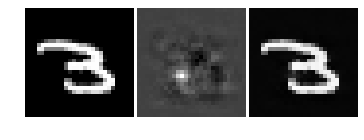

	label: 3 0.6761339 -> 0.40215468
	target: 2 0.18515798 -> 0.4021544


In [344]:
im_num = 250

# pick im + attack
ats = ['fgsm', 'saliency', 'gradientattack', 'deepfoolattack', 'boundaryattack']
vals = []
for attack_type in ats:
    # generate attack
    im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv = attack_helper.attack_im_num(im_num, attack_type)
    vals.append((im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv))
    attack_helper.plot_attack(im_orig, im_orig_adv, label, target, pred_orig, pred_adv)

	label: 3 0.6761339 -> 0.36680317
	target: 2 0.18515798 -> 0.37429506
	label: 3 0.6761339 -> 0.38183555
	target: 2 0.18515798 -> 0.40505022
	label: 3 0.6761339 -> 0.3753697
	target: 2 0.18515798 -> 0.39490557
	label: 3 0.6761339 -> 0.35067138
	target: 2 0.18515798 -> 0.44998848
	label: 3 0.6761339 -> 0.40215468
	target: 2 0.18515798 -> 0.4021544


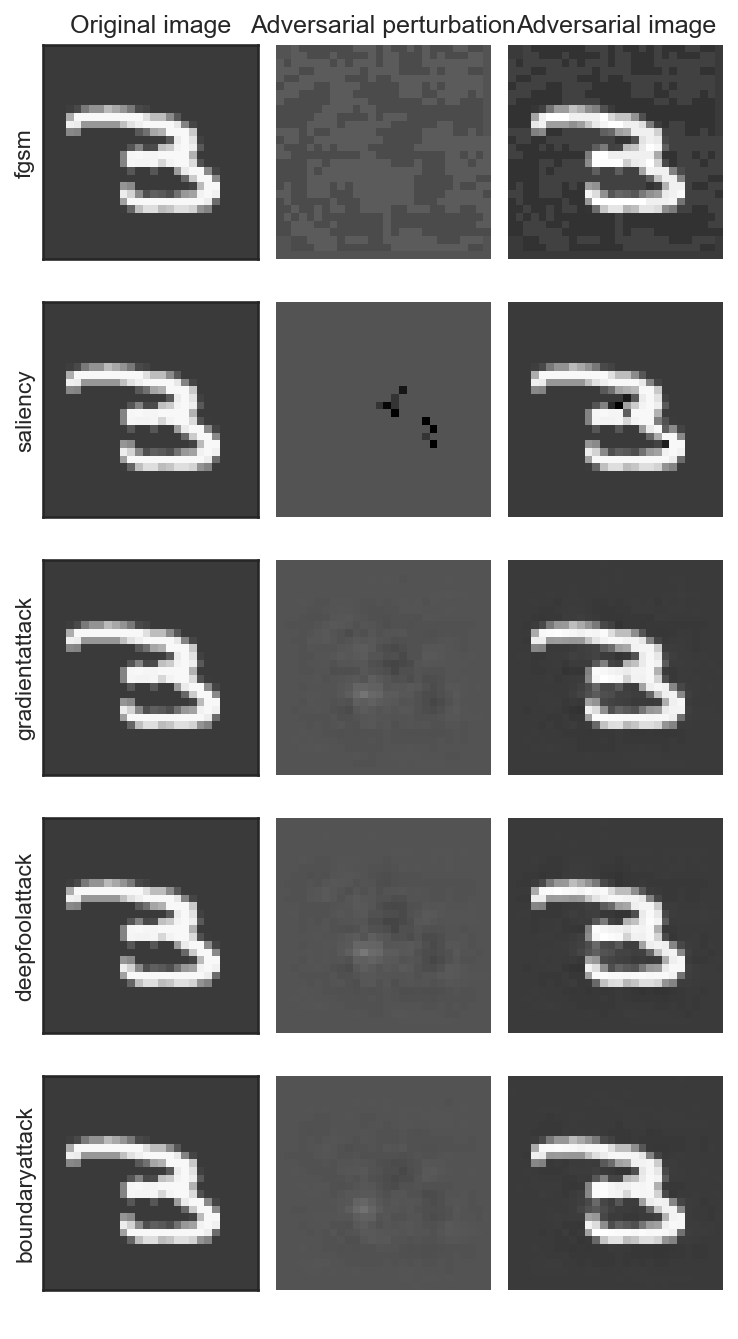

In [371]:
plt.figure(figsize=(6, 11), dpi=150)
num_rows = 5
num_cols = 3
vmin = 10
vmax = 0

# find min and max
for i, attack_type in enumerate(ats):
    (im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv) = vals[i]
    vmi = min([np.min(im) for im in [im_orig, im_orig_adv, im_orig - im_orig_adv]])
    vma = max([np.max(im) for im in [im_orig, im_orig_adv, im_orig - im_orig_adv]])
    vmin = min(vmi, vmin)
    vmax = max(vma, vmax)

for i, attack_type in enumerate(ats):
    (im_orig, im_torch, im_orig_adv, im_torch_adv, label, target, pred_orig, pred_adv) = vals[i]

#     attack_helper.plot_attack(im_orig, im_orig_adv, label, target, pred_orig, pred_adv)
    plt.subplot(num_rows, num_cols, num_cols * i + 1)

    plt.imshow(im_orig, cmap='gray', vmin=vmin, vmax=vmax)
    plt.gca().xaxis.set_visible(False) #('off')
    plt.gca().yaxis.set_ticks([]) #('off')
    if i == 0:
        plt.title('Original image')
    plt.ylabel(attack_type)

    plt.subplot(num_rows, num_cols, num_cols * i + 2)
    plt.imshow(im_orig_adv - im_orig, cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    if i == 0:
        plt.title('Adversarial perturbation')
        
    plt.subplot(num_rows, num_cols, num_cols * i + 3)
    plt.imshow(im_orig_adv, cmap='gray', vmin=vmin, vmax=vmax)
    plt.axis('off')
    if i == 0:
        plt.title('Adversarial image')
    print('\tlabel:', label, pred_orig[label], '->', pred_adv[label])
    print('\ttarget:', target, pred_orig[target], '->', pred_adv[target])        
plt.subplots_adjust(wspace=0)
plt.show()

